In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import os
import random
import math
import pandas as pd
import scipy
import numpy.ma as ma
import itertools
from networkx.algorithms import bipartite
import community
# from infomap import infomap
import os
import rpy2.robjects as robjects

In [4]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

In [5]:
data_total=ldata('crimen/red_crimenes')
sexos = ldata('crimen/moreno_crime/ent.moreno_crime_crime.person.sex')
nombres = ldata('crimen/moreno_crime/ent.moreno_crime_crime.person.name')
roles = ldata('crimen/moreno_crime/rel.moreno_crime_crime.person.role')

In [6]:
crimenes=[]
personas=[]
red_cr = []
usados = []
j = 0
for i in data_total:
    crimenes.append(i[1]+'cr')
    if i[0] not in usados:
        j = j + 1
        usados.append(i[0])
        personas.append(j)
    red_cr.append([j,i[1]+'cr']) # En su primer elemento contiene un número que indica a la persona.
                                 # almacenado esto mismo en lista "personas"
                                 # en su segundo elemento un str que contiene al crimen.
                                 # # almacenado esto mismo en lista "crimenes"

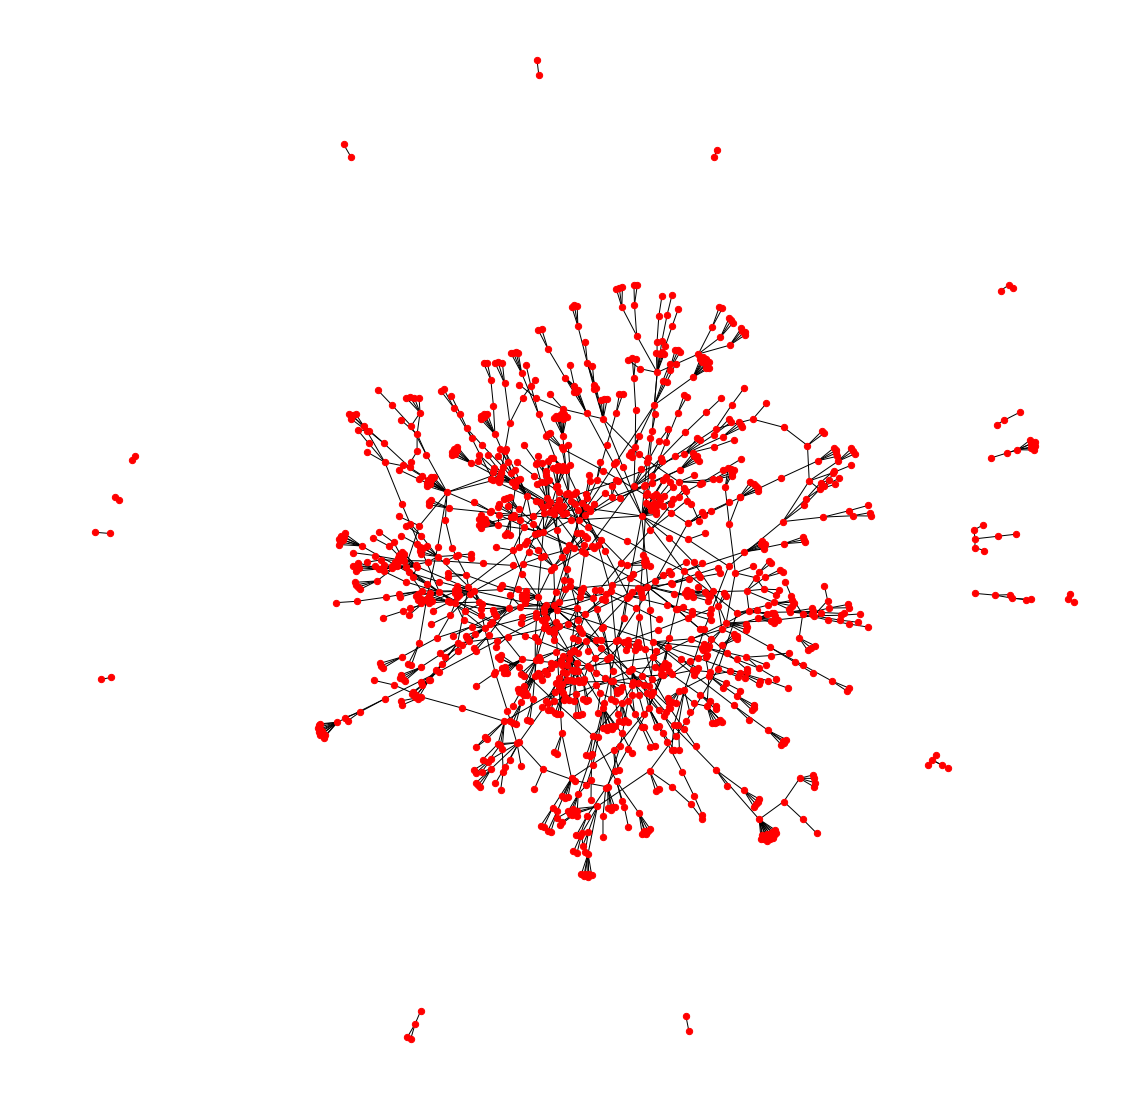

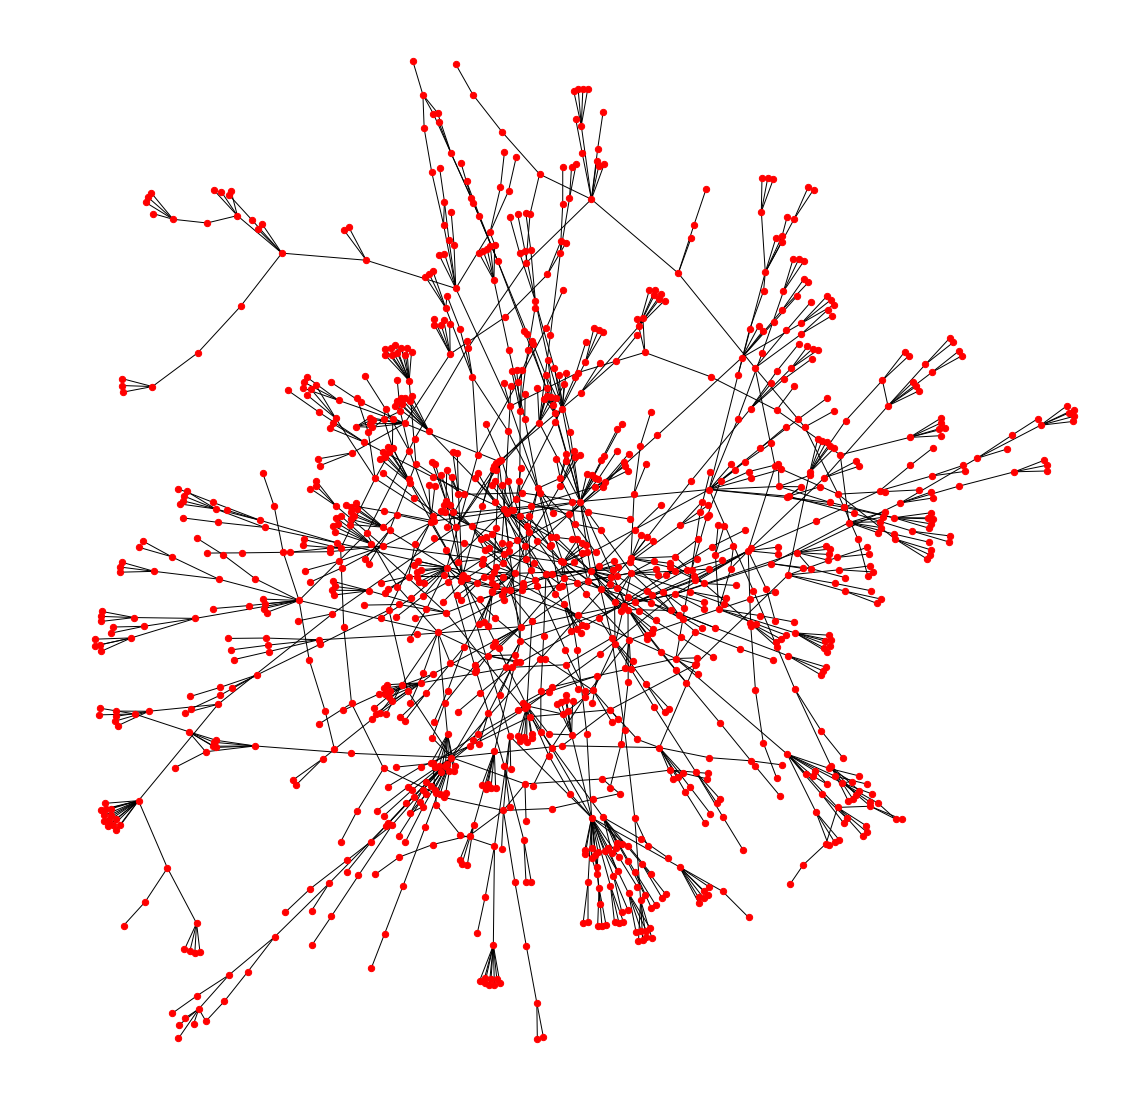

In [7]:
# Asignar esta bipartición despues nos permite armar la red persona - persona.

B = nx.Graph()
# Asigna dos valores de bipartición (0 y 1) para cada tipo de nodo (personas, crimenes)
B.add_nodes_from(personas, bipartite=0)
B.add_nodes_from(crimenes, bipartite=1)
# Agrega un enlace entre nodos de biparticiones diferentes.
B.add_edges_from(red_cr)

plt.figure(figsize=(15,15))
nx.draw(B,node_size = 40,with_labels=False, font_weight='bold')
plt.show()

Bmax = max(nx.connected_component_subgraphs(B), key=len)
plt.figure(figsize=(15,15))
nx.draw(Bmax,node_size = 40,with_labels=False, font_weight='bold')
plt.show()

In [8]:
# print(nombres[829])
#Asignacion universal de atributos (AUA)
for node in Bmax.nodes:
    if node in personas:
#         print("hola")
        Bmax.node[node]['color']='red'
        Bmax.node[node]['nombre']=nombres[node-1]
        Bmax.node[node]['rol']=roles[node-1]
        Bmax.node[node]['sexo']=sexos[node-1]
    elif node in crimenes:
#         print('FUNCIONA!!!')
        Bmax.node[node]['color']='blue'

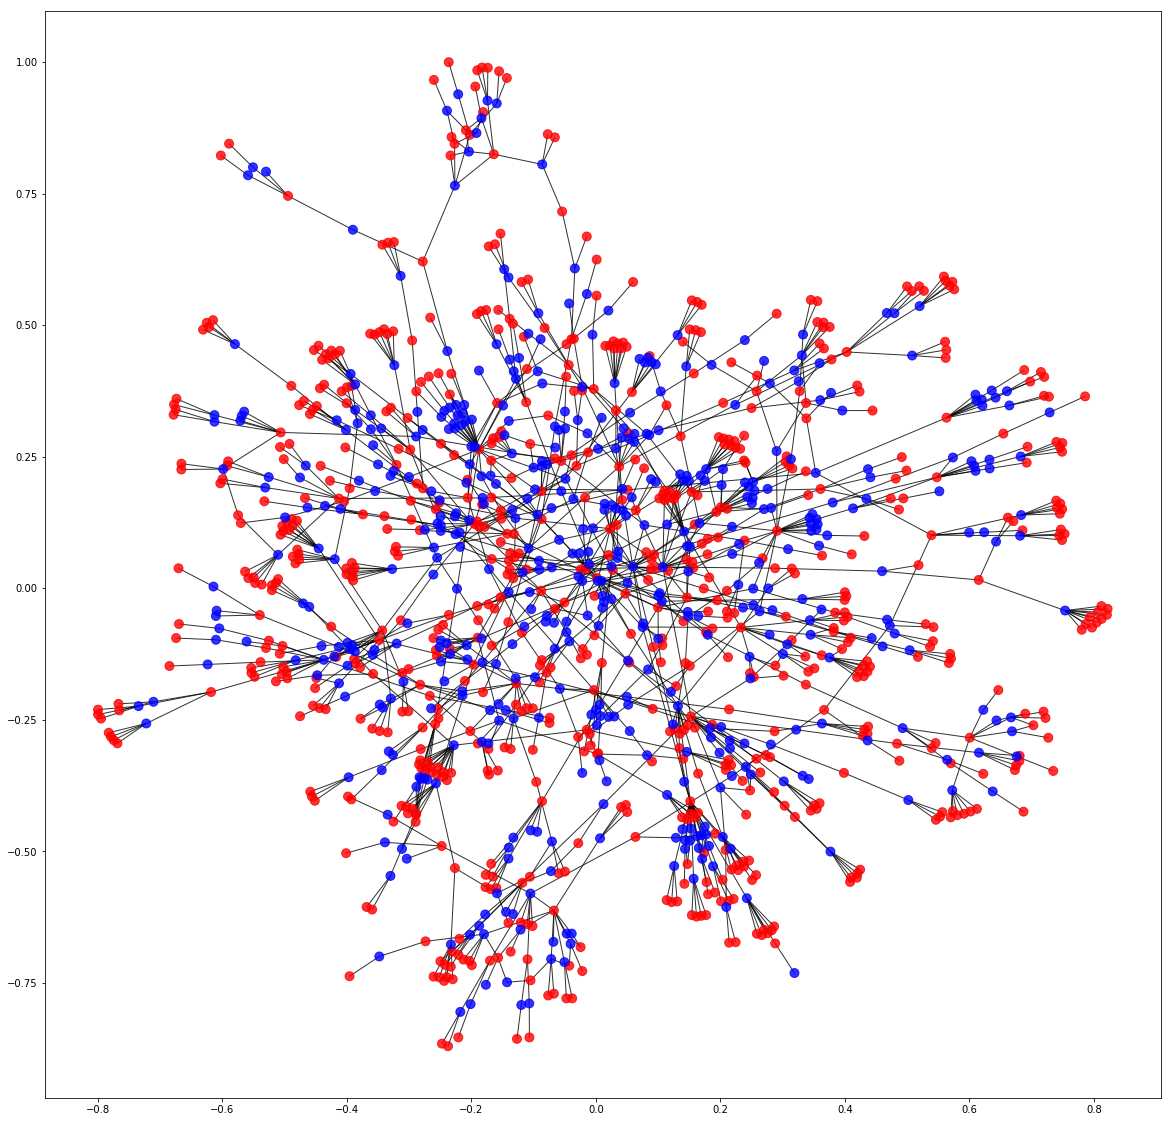

In [9]:
plt.figure(figsize=(20,20))
nx.draw_networkx(Bmax, node_color=list(nx.get_node_attributes(Bmax, "color").values()),
                 node_size=80,
                 alpha=0.8,
                 with_labels=False)
plt.show()

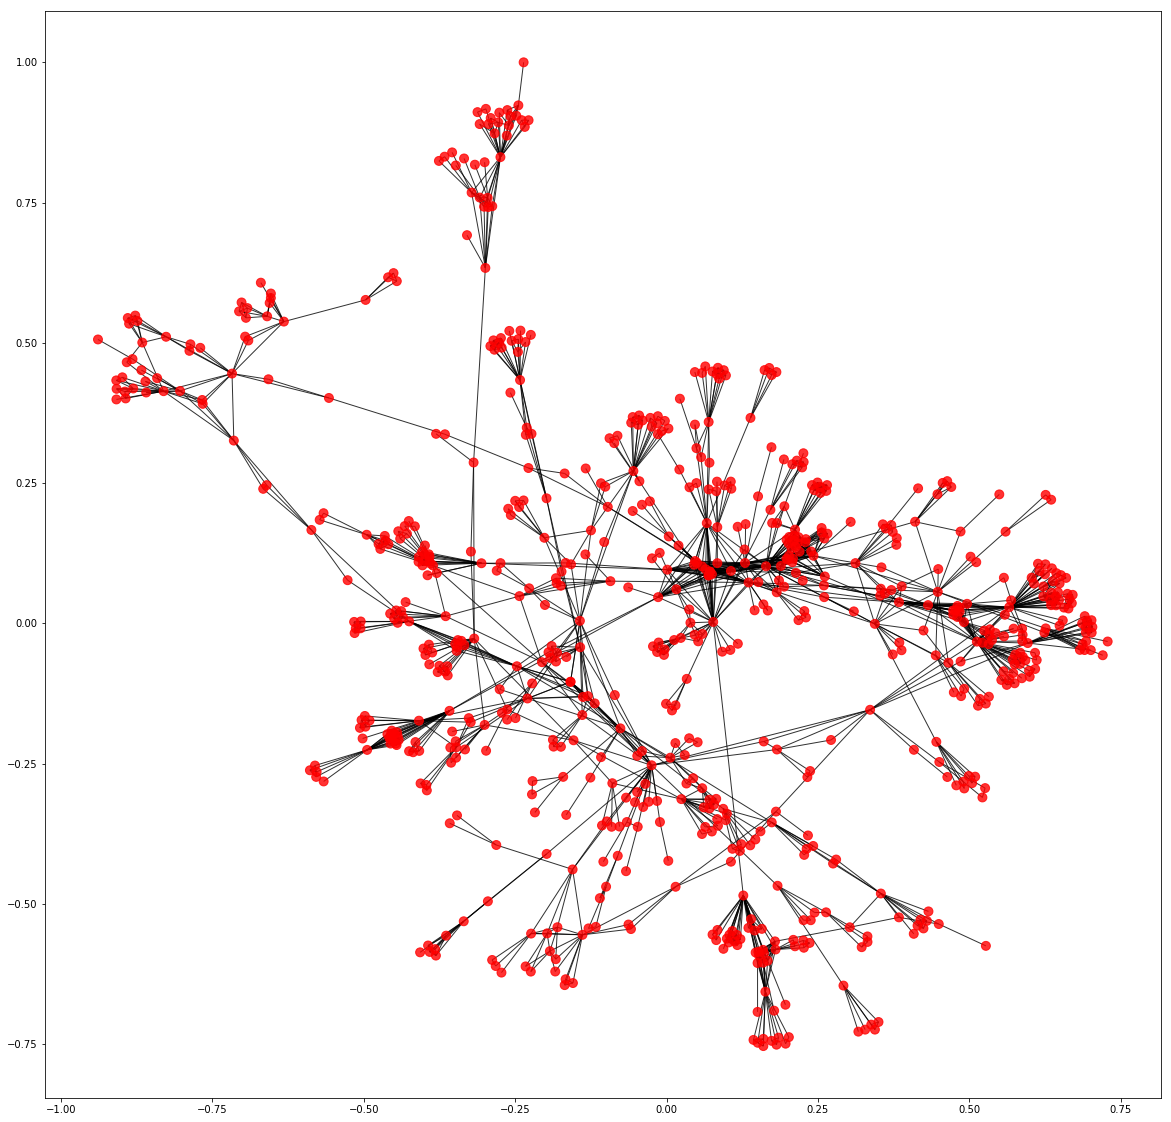

In [10]:
# Armamos la red Persona - Persona. 
# Peso de los enlaces: Nro. de vecinos compartidos (i.e. Nro. de crimenes compartidos)
# Armar con esto las comunidades --- ver lo de las componenetes gigantes

PP = max(nx.connected_component_subgraphs(nx.algorithms.bipartite.projection.weighted_projected_graph(B, personas, ratio=False)), key=len)

for node in PP.nodes:
    if node in personas:
#         print("hola")
        PP.node[node]['color']='red'
        PP.node[node]['nombre']=nombres[node-1]
        PP.node[node]['rol']=roles[node-1]
        PP.node[node]['sexo']=sexos[node-1]
    elif node in crimenes:
#         print('FUNCIONA!!!')
        PP.node[node]['color']='blue'

plt.figure(figsize=(20,20))
nx.draw_networkx(PP, node_color=list(nx.get_node_attributes(PP, "color").values()),
                 node_size=80,
                 alpha=0.8,
                 with_labels=False)
plt.show()

In [11]:
grados = nx.bipartite.degrees(Bmax, list(Bmax.nodes()), weight=None)
gpers=[]
gcrim = []
for node in Bmax.nodes:
    if node in personas:
        gpers.append(grados[1][node])
    if node in crimenes:
        gcrim.append(grados[1][node])

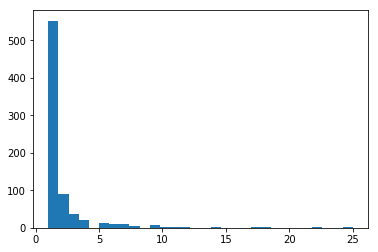

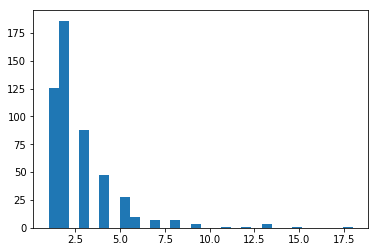

In [12]:
plt.hist(gpers,bins=30)
plt.show()

plt.hist(gcrim,bins=30)
plt.show()

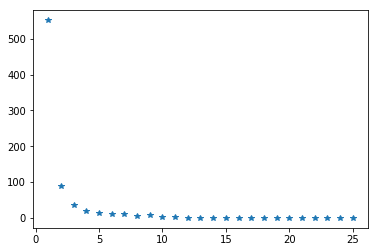

In [26]:
nro=np.linspace(1,max(gpers),max(gpers))
gradpers=np.zeros(len(nro))

for i in range(len(nro)):
    for g in gpers:
        if g==i+1:
            gradpers[i]=gradpers[i]+1
plt.plot(nro,gradpers,'*')
plt.show()

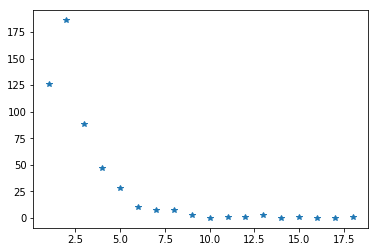

In [31]:
nrocr=np.linspace(1,max(gcrim),max(gcrim))
gradcrim=np.zeros(len(nrocr))
for i in range(len(nrocr)):
    for g in gcrim:
        if g==i+1:
            gradcrim[i]=gradcrim[i]+1
plt.plot(nrocr,gradcrim,'*')
plt.show()